In [1]:
from datetime import datetime, timedelta
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pypfopt.cla import CLA
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
import yfinance as yf

sys.path.append('..')
from util.batcher import Batcher
#from util.stock_loader import Loader

In [2]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 10
START = TODAY - timedelta(YEARS_OF_DATA * 365)
START, TODAY

(datetime.date(2012, 8, 8), datetime.date(2022, 8, 6))

In [3]:
sharpes = pd.read_csv('sharpes.csv')
sharpes.head()

,stock,sharpe
0,ASAN,4.146624
1,efc,3.530101
2,stry,3.398456
3,lly,3.048137
4,eve,2.531150


<a href="https://www.advfn.com/nyse/newyorkstockexchange.asp?companies=Y">NYSE listings</a>

In [6]:
KEEP_TOP_N = 50
sym = (
    'wavc w we weav webr wbs wri wmk wbt wcg wfc well wair wfg wst wrk mmu '
    'wal wala tli wdi esd emd gdo ehi gdf hix hio hyi wia wiw sbi igi '
    'pai wmc dmo mtt mhf mnp wea gfy wes wnr wu wlkp wlk whg wy wpm up '
    'whr wtm wsr wll wow wlh wmb wrac wsm wbev wgo wolf www wf wspt int '
    'wqga wwe wp wor wynd wh xflt xl xoxo xpo xhr xrx xpof xue xyl yeti'
)
missing = (
    'wair xue gdf mtt wspt wnr wri wp gfy esd wlh wynd tli wcg'
)
SYMBOLS = [s for s in sym.split() if s not in missing.split()]
#SYMBOLS

In [7]:
data = (
    yf.download(SYMBOLS, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']
data.columns = SYMBOLS
data.head()

[*********************100%***********************]  68 of 68 completed


,wavc,w,we,weav,webr,wbs,wmk,wbt,wfc,well,...,wh,xflt,xl,xoxo,xpo,xhr,xrx,xpof,xyl,yeti
Date,,,,,,,,,,,,,,,,,,,,,
2012-08-08,7.100306,5.398858,9.190726,9.226628,3.022229,3.983369,8.634469,13.956491,32.438091,5.459776,...,16.137606,NaN,NaN,NaN,8.42,8.585565,NaN,13.500180,21.082613,NaN
2012-08-09,7.121127,5.398858,9.199432,9.273557,3.036093,4.010495,8.630029,13.771918,32.868889,5.511897,...,16.089571,NaN,NaN,NaN,8.55,8.463329,NaN,13.575916,21.361959,NaN
2012-08-10,7.156824,5.359042,9.173306,9.268862,3.045335,4.022120,8.634469,13.599247,32.795555,5.479321,...,16.151327,NaN,NaN,NaN,8.42,8.352736,NaN,13.594853,21.353239,NaN
2012-08-13,7.091380,5.402839,9.164604,9.217238,3.026850,4.018245,8.536754,13.617118,32.493084,5.401139,...,16.281691,NaN,NaN,NaN,8.31,8.428405,NaN,13.613787,21.396879,NaN
2012-08-14,7.094357,5.438670,9.208143,9.207858,3.049958,4.025995,8.567844,13.623066,32.914730,5.362047,...,16.261103,NaN,NaN,NaN,8.21,8.696158,NaN,13.594853,21.004045,NaN


In [8]:
def get_daily_returns(x):
    n = len(x)
    x = np.array(x)
    return x[2:n] / x[1:(n - 1)] - 1 

In [9]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [10]:
new_sharpes = []
for stock in SYMBOLS:
    sharpe = get_sharpe(get_daily_returns(data[stock]))
    new_sharpes.append([stock, sharpe])

In [11]:
sharpe_df = (
    pd.DataFrame(new_sharpes, columns=['stock', 'sharpe'])
    .sort_values('sharpe', ascending=False))
sharpe_df.head(15)

,stock,sharpe
53,wf,1.187370
49,wbev,0.865168
62,xpo,0.853698
56,wwe,0.781405
16,wdi,0.763166
67,yeti,0.734551
48,wsm,0.719543
66,xyl,0.701863
64,xrx,0.699763
63,xhr,0.653072


In [12]:
sharpes_df = (
    pd.concat([sharpes, sharpe_df])
    .sort_values('sharpe', ignore_index=True, ascending=False)
    .drop_duplicates())
sharpes_df.drop_duplicates(subset=['stock'], inplace=True)
sharpes_df.index = sharpes_df['stock']
sharpes_df.drop(columns=['stock'], inplace=True)

sharpes_df.head(20)

,sharpe
stock,
ASAN,4.146624
efc,3.530101
stry,3.398456
lly,3.048137
eve,2.531150
chmt,2.475858
hhs,2.406309
bxsl,2.249160
dwin,1.886962


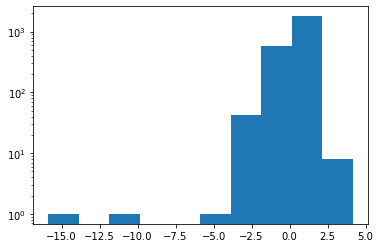

In [13]:
plt.hist(sharpes_df.sharpe)
plt.yscale('log');

In [14]:
sharpes.loc[sharpes.stock == 'sfg', :]

,stock,sharpe


In [15]:
omit = 'dcue'
inds = []
for o in omit.split():
    inds += (sharpes.loc[sharpes.stock == o, :].index.tolist())

sharpes.drop(index=inds, inplace=True)

In [16]:
sharpes.to_csv('sharpes.csv', index=False)

In [17]:
sharpes.shape

(2652, 2)

In [18]:
MIX = sharpes.stock.unique().tolist()[:400]
len(MIX)
df = yf.download(MIX, start=START, end=TODAY)
df.drop(
    columns=['Open', 'Close', 'Volume', 'High', 'Low'], inplace=True)
print(df.shape)
df.head()

[*********************100%***********************]  400 of 400 completed
(2517, 400)


Adj Close                                                     \
                  ABC      ABEV        ABM ACA      ACRE ADCT        ADM   
Date                                                                       
2012-08-08  33.010452  4.547414  15.362301 NaN  7.060803  NaN  20.145580   
2012-08-09  33.001915  4.550342  15.402918 NaN  7.094665  NaN  20.137970   
2012-08-10  33.001915  4.557662  15.443533 NaN  7.094665  NaN  19.734756   
2012-08-13  32.916622  4.529845  15.443533 NaN  7.065036  NaN  19.727144   
2012-08-14  32.660732  4.544485  15.419165 NaN  6.976137  NaN  19.776930   

                                            ...                            \
                 AEG        AEL        AEO  ... WDH       WLYB        WMT   
Date                                        ...                             
2012-08-08  3.193619  10.231776  14.909007  ... NaN  37.178303  59.668201   
2012-08-09  3.341709  10.268127  14.985786  ... NaN  37.178303  59.298847   
2012-08-10  3.399659  10.186345  14.608871  ... NaN  37.115986  59.162346   
2012-08-13  3.367464  10.268127  14.546053  ... NaN  36.921299  58.937523   
2012-08-14  3.386780  10.322645  14.546053  ... NaN  36.921299  59.427338   

                                                                
           WNNR WPCA        WRE        WSO        XOM XPOA YOU  
Date                                                            
2012-08-08  NaN  NaN  17.242781  49.978580  58.089695  NaN NaN  
2012-08-09  NaN  NaN  17.132374  49.985588  58.414223  NaN NaN  
2012-08-10  NaN  NaN  17.093412  50.217247  58.573185  NaN NaN  
2012-08-13  NaN  NaN  17.073921  50.498001  58.374496  NaN NaN  
2012-08-14  NaN  NaN  17.034958  51.164867  58.414223  NaN NaN  

[5 rows x 400 columns]

In [19]:
df.columns = MIX
MAX_MISSING = 30
n_nan = df.isnull().sum()
n_nan
drop = n_nan[n_nan > MAX_MISSING].index
df = df.drop(columns=drop)
print(df.shape)
df.head()

(2517, 230)


,ASAN,efc,stry,eve,hhs,bxsl,dwin,swi,pnw,irs,...,hr,mixt,thr,tinv,ohi,jbgs,cni,rcc,cah,tslx
Date,,,,,,,,,,,,,,,,,,,,,
2012-08-08,33.010452,4.547414,15.362301,7.060803,20.145580,3.193619,10.231776,14.909007,17.207525,4.997663,...,30.577265,7.695765,8.524115,37.291359,11.232469,37.178303,59.668201,17.242781,49.978580,58.089695
2012-08-09,33.001915,4.550342,15.402918,7.094665,20.137970,3.341709,10.268127,14.985786,17.307280,5.067808,...,29.961746,7.673888,8.703838,37.277069,11.214264,37.178303,59.298847,17.132374,49.985588,58.414223
2012-08-10,33.001915,4.557662,15.443533,7.094665,19.734756,3.399659,10.186345,14.608871,17.207525,5.085343,...,30.096975,7.656388,8.763747,37.925350,10.922984,37.115986,59.162346,17.093412,50.217247,58.573185
2012-08-13,32.916622,4.529845,15.443533,7.065036,19.727144,3.367464,10.268127,14.546053,16.908264,5.120418,...,29.917456,7.637006,8.695282,37.620270,10.759139,36.921299,58.937523,17.073921,50.498001,58.374496
2012-08-14,32.660732,4.544485,15.419165,6.976137,19.776930,3.386780,10.322645,14.546053,16.609001,5.137949,...,30.283501,7.650221,8.506998,37.887215,11.159648,36.921299,59.427338,17.034958,51.164867,58.414223


In [20]:
import cvxpy
cvxpy.installed_solvers()

['ECOS', 'ECOS_BB', 'OSQP', 'SCIPY', 'SCS']

In [21]:
mu = mean_historical_return(df)
s = CovarianceShrinkage(df).ledoit_wolf()
ef = EfficientFrontier(mu, s, solver='ECOS')# , verbose=True)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
for k, v in dict(cleaned_weights).items():
    if v > 0:
        print(f'{k:6s}: {v}')

fmc   : 0.01542
hrl   : 0.01446
cmcm  : 0.00154
sxt   : 0.05923
rad   : 0.01738
trv   : 0.03814
mov   : 0.02787
crhc  : 0.02748
ip    : 0.00537
hmn   : 0.10929
kar   : 0.00746
fif   : 0.07419
eqgp  : 0.02623
dma   : 0.06864
renx  : 0.19463
msge  : 0.12422
gcv   : 0.11683
rc    : 0.04983
cah   : 0.02178


In [22]:
_, _, s1 = ef.portfolio_performance(verbose=True)

Expected annual return: 22.0%
Annual volatility: 13.0%
Sharpe Ratio: 1.54


In [23]:
s1

1.5419324366567217

In [24]:
vol = np.linspace(0.10, 0.30, 50)
rets = []
sharpes = []
for v in vol:
    print(f'Vol: {v}   ', end='\r')
    ef = EfficientFrontier(mu, s, solver='ECOS')
    w = ef.efficient_risk(target_volatility=v)
    r, _, sh = ef.portfolio_performance()
    rets.append(r)
    sharpes.append(sh)

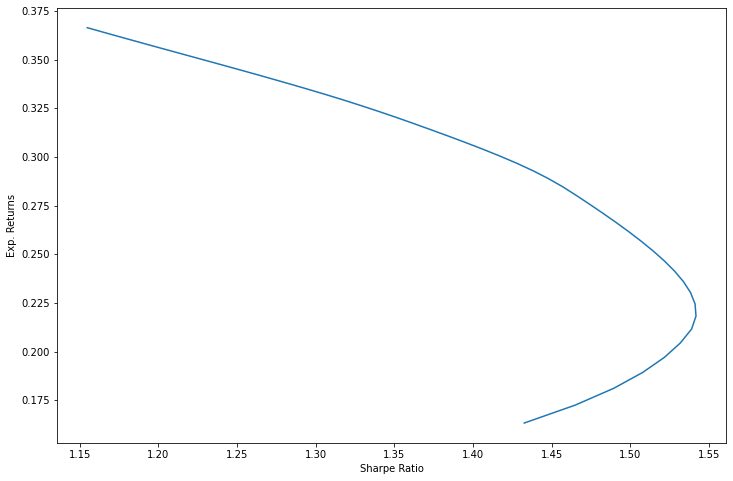

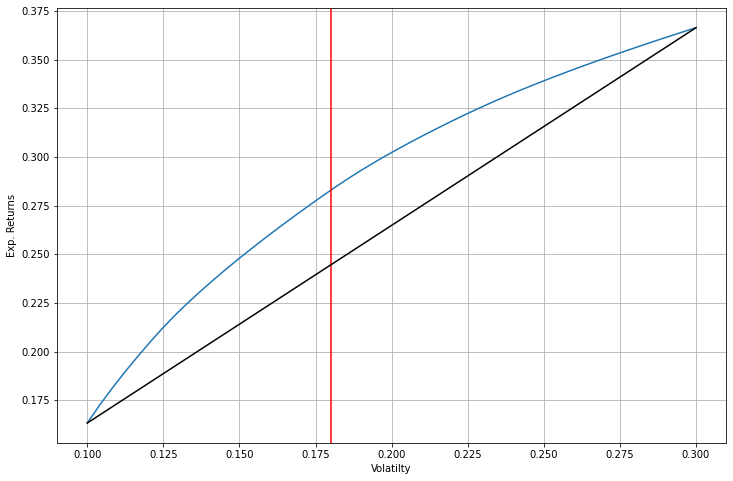

In [31]:
plt.figure(figsize=[12,8])
plt.plot(sharpes, rets)
plt.xlabel('Sharpe Ratio')
plt.ylabel('Exp. Returns');

plt.figure(figsize=[12,8])
plt.plot(vol, rets)
plt.grid(True)
plt.axvline(x=0.18, color='r')
plt.plot([0.1, 0.3], [rets[0], rets[-1]], color='k')
plt.xlabel('Volatilty')
plt.ylabel('Exp. Returns');

In [32]:
OPTIMAL_VOL = 0.18
ef = EfficientFrontier(mu, s, solver='ECOS')
weights = ef.efficient_risk(target_volatility=OPTIMAL_VOL)
cleaned_weights = dict(ef.clean_weights())
weights = {k: v for k, v in cleaned_weights.items() if v > 0}
for k, v in weights.items():
    print(f'{k:6s}: {v}')

fmc   : 0.03173
hrl   : 0.01669
cmcm  : 0.00974
sxt   : 0.07388
trv   : 0.00836
hmn   : 0.16476
kar   : 0.00977
fif   : 0.10381
eqgp  : 0.06776
dma   : 0.02948
msge  : 0.21038
gcv   : 0.21422
rc    : 0.05942


In [33]:
_, _, s1 = ef.portfolio_performance(verbose=True)

Expected annual return: 28.3%
Annual volatility: 18.0%
Sharpe Ratio: 1.46


In [34]:
s1

1.460623151682654

In [35]:
sharpes_df.loc[weights.keys(), 'sharpe']

stock
fmc     1.546894
hrl     1.320501
cmcm    1.010863
sxt     0.992081
trv     0.913207
hmn     0.770981
kar     0.766604
fif     0.740030
eqgp    0.735395
dma     0.695828
msge    0.664737
gcv     0.663361
rc      0.660977
Name: sharpe, dtype: float64